# The Quarterly Japanese Economic Model (Q-JEM)
This workbook implement the "The Quarterly Japanese Economic Model (Q-JEM): 2019 version". 

At http://www.boj.or.jp/en/research/wps_rev/wps_2019/wp19e07.htm/ you will find the working paper describing 
the model and a zipfile containing all the relevant information needed to use the model. 

The model logic has been transformed from Eview equation to ModelFlow Business logic and the dataseries has been transformed to a Pandas Dataframe. 

In this workbook the impulse responses from the working paper section 3.1.1, 3.1.2, 3.1.3, and 3.1.4 has been recreated. 

# Import Python libraries

In [33]:
import pandas as pd 

import sys
sys.path.append('modelflow/')

from modelsandbox import newmodel
import modelnet as mn

# Create model and dataframe 

In [34]:
with open('QJEM/model/fqjem.frm','rt') as f: 
    fqjem =f.read()
baseline = pd.read_pickle('QJEM/data/dfqjem.pk')    

mqjem = newmodel(fqjem)

mqjem.use_preorder = 1 # make a block decomposition of the model 
turbo = 0              # 1 sppeds up by compiling with Numba, 0 use straight python 

This model has simultaneous elements or cyclical elements.


# Define some variable labels 

In [35]:
legend = {
'GDP'   : 'Real gross domestic product, S.A.',
'CP'    : 'Real private consumption, S.A.',
'U'     : 'Unemployment rate, S.A.',
'PGDP'  : 'GDP deflator',
'USGDP' : 'Real gross domestic product of the United States, S.A.',
'NUSGDP': 'Output gap of the rest of the world',
'EX': 'Real exports of goods and services, S.A.',
'IM' : 'Real imports of goods and services, S.A.',
'INV' : 'Real private non-residential investment, S.A.',
'CORE_CPI' : 'Consumer price index (all items, less fresh food), S.A.'
}

# Run the baseline 

In [36]:
res = mqjem(baseline,antal=50,first_test = 1,ljit=turbo,chunk=49,silent=1)

# Make experiment with Foreign GDP +1 percent point. 

In [37]:
instruments = [ 'V_NUSGAP','V_USGAP']
target      = baseline.loc['2005q1':,['USGDP','NUSGDP']].mfcalc('''\
USGDP  = USGDP*1.01
NUSGDP = NUSGDP*1.01
''',silent=1)
resalt = mqjem.control(baseline,target,instruments,silent=1)

# Display the results 

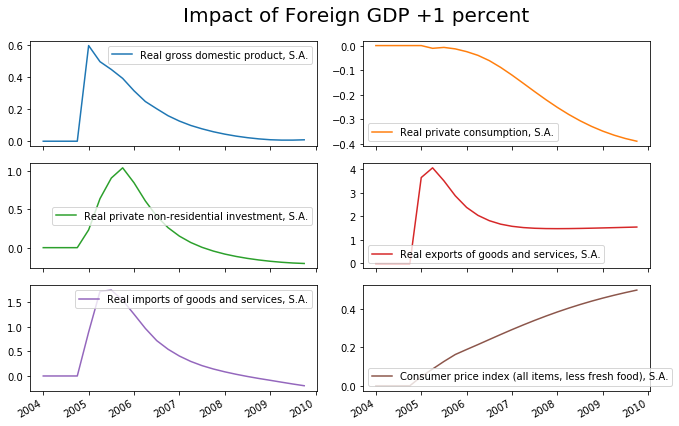

In [38]:
disp = mqjem['GDP CP INV EX IM CORE_CPI'].difpctlevel.mul100.rename(legend).plot(
    colrow=2,sharey=0,title='Impact of Foreign GDP +1 percent',top=0.9)

# Lower Oil prices  

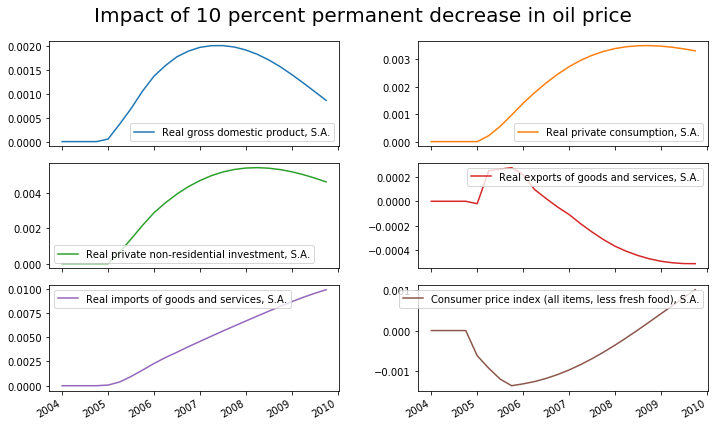

In [39]:
instruments = [ 'V_POIL']
target      = baseline.loc['2005q1':,['POIL']].mfcalc('''\
POIL  = POIL*0.9
''',silent=1)

resalt = mqjem.control(baseline,target,instruments,silent=1)

disp = mqjem['GDP CP INV EX IM CORE_CPI'].difpctlevel.rename(legend).plot(
    colrow=2,sharey=0,title='Impact of 10 percent permanent decrease in oil price',top=0.9)

# Combine the two previous experiments 

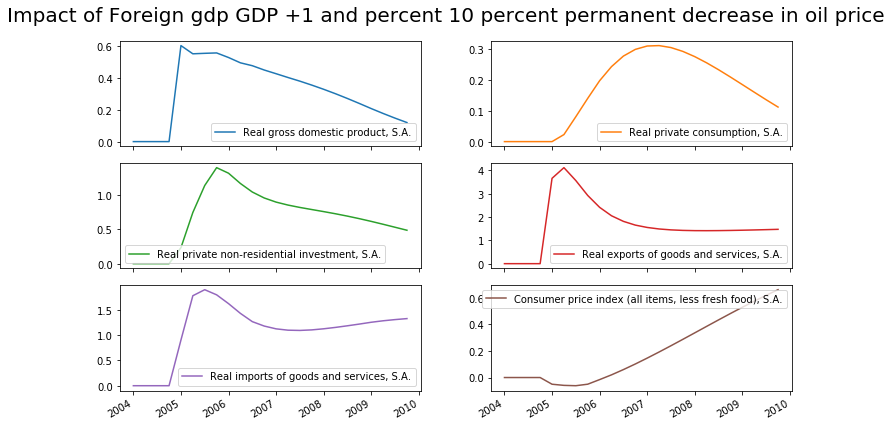

In [40]:
instruments = [ 'V_POIL','V_NUSGAP','V_USGAP']
target      = baseline.loc['2005q1':,['POIL','USGDP','NUSGDP']].mfcalc('''\
POIL  = POIL*0.9
USGDP  = USGDP*1.01
NUSGDP = NUSGDP*1.01
''',silent=1)

resalt = mqjem.control(baseline,target,instruments,silent=1)

disp = mqjem['GDP CP INV EX IM CORE_CPI'].difpctlevel.mul100.rename(legend).plot(
    colrow=2,sharey=0,title='Impact of Foreign gdp GDP +1 and percent 10 percent permanent decrease in oil price',top=0.9)

# A permanent depreciation of exchange rates. 

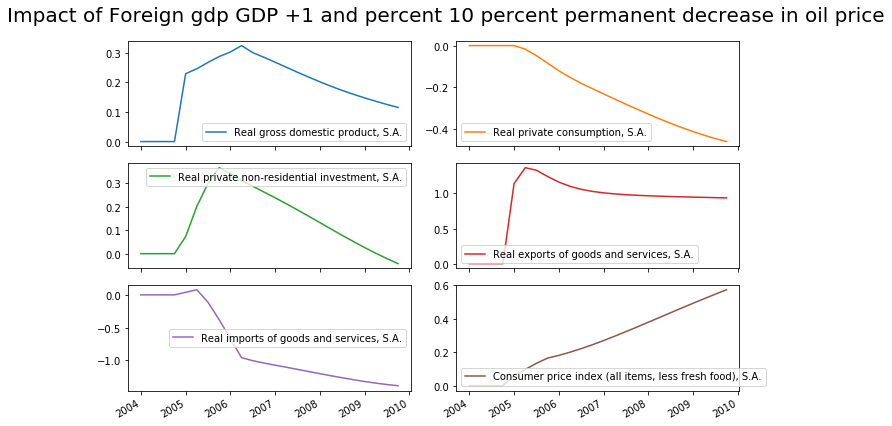

In [41]:
instruments = [ 'V_FXYEN']
target      = baseline.loc['2005q1':,['FXYEN']].mfcalc('''\
FXYEN = FXYEN*1.1
''',silent=1)

resalt = mqjem.control(baseline,target,instruments,silent=1)

disp = mqjem['GDP CP INV EX IM CORE_CPI'].difpctlevel.mul100.rename(legend).plot(
    colrow=2,sharey=0,title='Impact of Foreign gdp GDP +1 and percent 10 percent permanent decrease in oil price',top=0.9)

# Draw the causal structure 

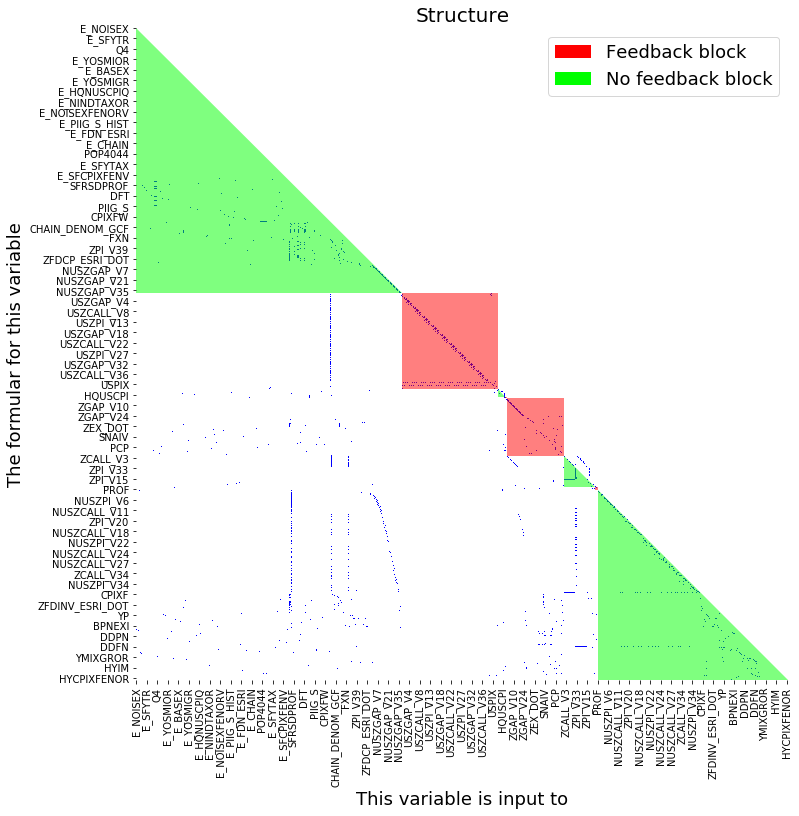

In [42]:
    fig2 = mn.draw_adjacency_matrix(mqjem.endograph,mqjem.precoreepiorder,mqjem._superstrongblock,mqjem._superstrongtype,
                                    size=(12,12))

# How is CPQ determined 

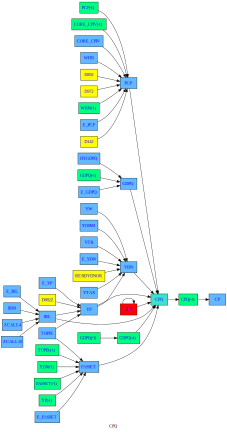

In [43]:
mqjem.cpq.draw(up=2,down=2,HR=0,svg=1,transdic= {'ZPI*' : 'ZPI'}) # we condens all ZPI to one, to make the chart easy

## Also with values 
The result can be inspected in the graph/subfolder in PDF format. 

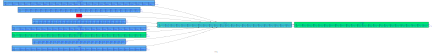

In [44]:
mqjem.cpq.draw(up=1,down=1,HR=0,svg=1,transdic= {'ZPI*' : 'ZPI'},last=1) # we condens all ZPI to one, to make the chart easy

# Another Example 

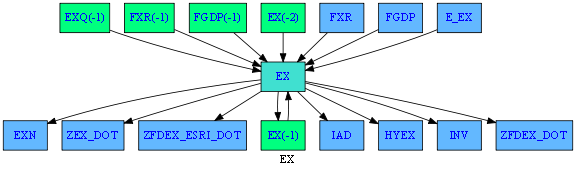

In [45]:
mqjem.ex.draw(up=1,down=1)

In [46]:
mqjem.ex

Endogeneous: EX 
Formular: FRML  <> EX = EX(-1)*EXP(E_EX + -0.02639388470328797 + -0.2283080859599746*LOG(EX(-1)/EXQ(-1)) + 0.228685192555833*LOG(EX(-1)/EX(-2)) + 3.603159894694305*LOG(FGDP/FGDP(-1)) + -0.139651427723068*LOG(FXR/FXR(-1))) $
Values : 
            2004Q1        2004Q2        2004Q3        2004Q4       2005Q1  \
Base  8.352800e+04  8.352800e+04  8.352800e+04  8.352800e+04  83528.00000   
Last  8.352800e+04  8.352800e+04  8.352800e+04  8.352800e+04  84480.98519   
Diff  1.164153e-10  1.149601e-09  4.947651e-10  8.731149e-11    952.98519   

            2005Q2       2005Q3        2005Q4        2006Q1        2006Q2  \
Base  83528.000000  83528.00000  83528.000000  83528.000000  83528.000000   
Last  84670.338442  84639.41383  84564.981481  84498.658078  84448.615076   
Diff   1142.338442   1111.41383   1036.981481    970.658078    920.615076   

          ...             2007Q3        2007Q4       2008Q1        2008Q2  \
Base      ...       83528.000000  83528.000000  83528.